In [1]:
# Установка библиотек
# ! pip install -r requirements.txt

# Импорты библиотек

In [2]:
import re
from tqdm import tqdm 
from datasets import load_dataset 
from llama_index.llms.ollama import Ollama
from llama_index.core.llms import ChatMessage

c:\Users\Asus\Documents\GitHub\llamaindex_RAG_MLLM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Исследование моделей ollama


## Первые запросы к модели

В качестве модели возьмём модель - llama3.2:1b (модель была запущена локально)

In [3]:
# Посмотрим на ту модель которая есть на GR
! ollama list

NAME               ID              SIZE      MODIFIED    
llama3.2:latest    a80c4f17acd5    2.0 GB    10 days ago    


Протестируем модель. 
Выбранная модель - llama3.2:latest

Попросим модель описать информацию о ней-же:
`Hello! I'm an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI." It's a type of sequence-to-sequence model that uses transformer architecture to process and generate human-like language. My primary function is to understand and respond to natural language inputs, and I can be used in various applications such as chatbots, language translation, text summarization, and more.`

<!-- Перевод на русский:  
`Привет! Я модель искусственного интеллекта, известная как Лама. Лама означает «Большая языковая модель мета-ИИ». Это тип модели «последовательность-последовательность», которая использует архитектуру преобразователя для обработки и генерации человеческого языка. Моя основная функция — понимать и реагировать на вводимые данные на естественном языке, и меня можно использовать в различных приложениях, таких как чат-боты, языковой перевод, обобщение текста и многое другое».` -->

In [4]:
# from llama_index.llms.ollama import Ollama

# В первый раз ставим время побольше, чтобы модель установилась
llm = Ollama(model="llama3.2:latest", request_timeout=120.0)

# llm.complete('Hello. How are you?')

# Напишем запрос к модели
prompt = """
Hello. Tell us what kind of model you are.
"""
mesage = llm.complete(prompt)

print(mesage.text)

Hello! I'm an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."


Супер. Модель с нами общается))
Посмотрим, на неё более подробно:

**Описание модели:**
- general.basename -- *Llama-3.2*
- general.languages -- *[en, de, fr, it, pt, ...]*
- general.size_label -- *3B*
- general.quantization_version -- *2*

**Характеристики модели:**
- llama.attention.head_count -- *24*
- llama.attention.head_count_kv -- *8*
- llama.vocab_size -- *128256*

**Использование модели:**
- Following instructions
- Summarization
- Prompt rewriting
- Tool use


## Результаты на бренчмарках

Давайте рассмотрим результаты бенчмаркинга, которые предоставляет наша модель. Мы протестируем её на одном из самых популярных наборов данных — MMLU, который можно скачать с Hugging Face. После этого мы запустим модель на этом датасете и проанализируем полученные результаты.

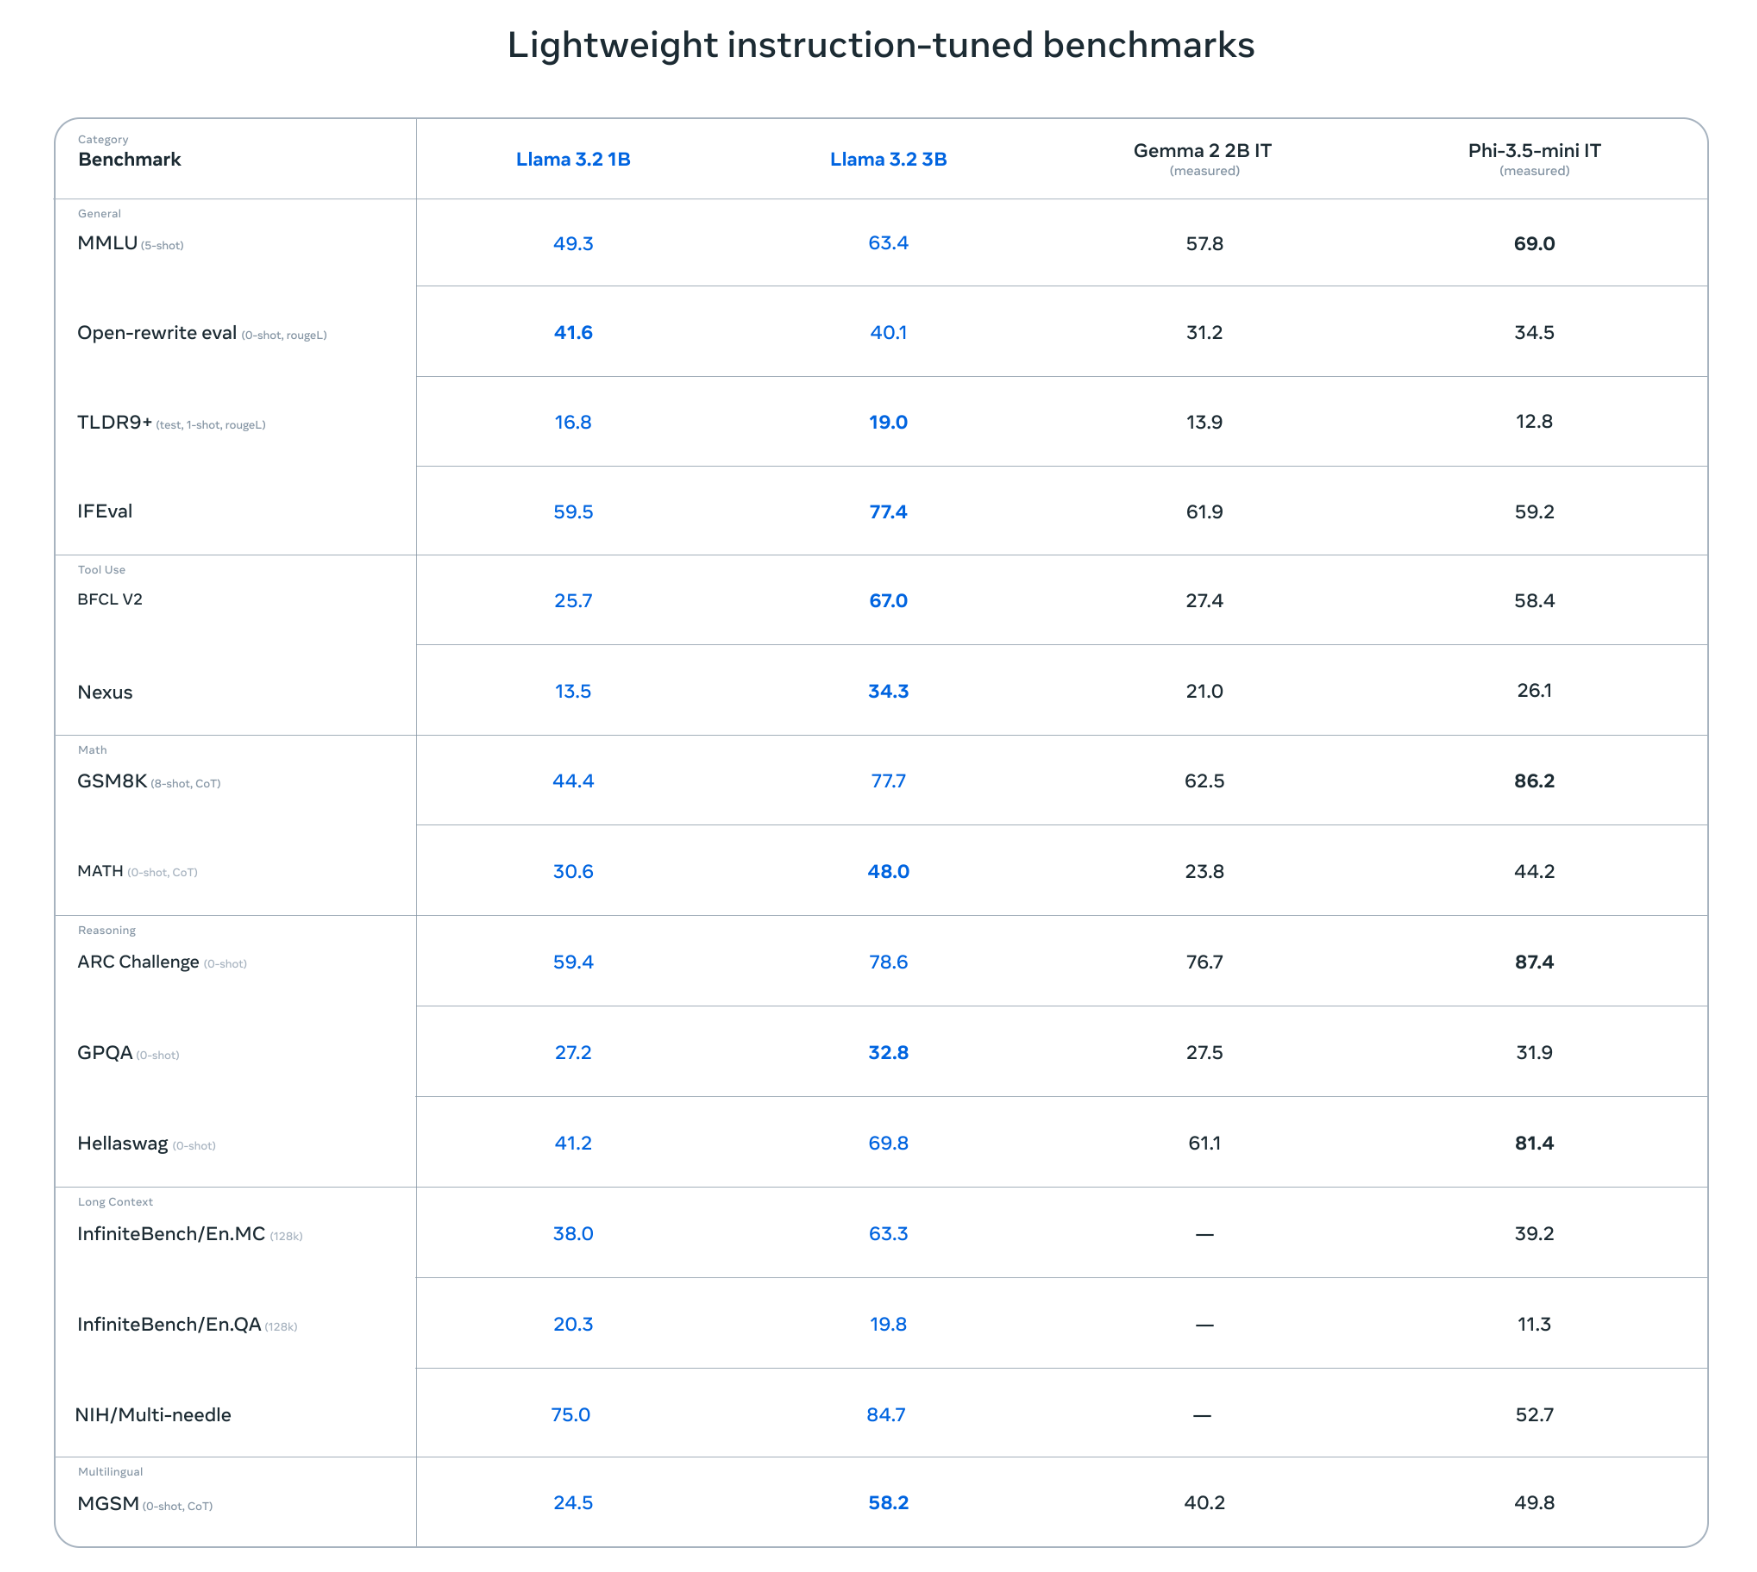

Посмотрим на датасет. Загрузим только несколько тем, которые нам интересны:
(Выберем 2 шт)
- astronomy
- elementary_mathematics

[Ссылка на датасет](https://huggingface.co/datasets/cais/mmlu)

In [5]:
# Ссылка на датасет
# https://huggingface.co/datasets/cais/mmlu

# from datasets import load_dataset

# Загрузим датасеты - astronomy, elementary_mathematics
data_astronomy = load_dataset('cais/mmlu', 'astronomy')
data_math = load_dataset('cais/mmlu', 'elementary_mathematics')

Using the latest cached version of the dataset since cais/mmlu couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'astronomy' at C:\Users\Asus\.cache\huggingface\datasets\cais___mmlu\astronomy\0.0.0\c30699e8356da336a370243923dbaf21066bb9fe (last modified on Thu Dec 26 00:06:23 2024).
Using the latest cached version of the dataset since cais/mmlu couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'elementary_mathematics' at C:\Users\Asus\.cache\huggingface\datasets\cais___mmlu\elementary_mathematics\0.0.0\c30699e8356da336a370243923dbaf21066bb9fe (last modified on Thu Dec 26 00:08:02 2024).


In [6]:
def print_data(data):
    for _, v in enumerate(data):
        print(f'{v}: {data[v]}')

# Посмотрим из чего состоят датасеты
print(data_astronomy.keys())
print(data_math.keys())

# Посмотрим на примеры вопросов с каждого из датасетов
print('\nПример для датасета по астрономии:')
print_data(data_astronomy['test'][0])
print('\nПример для датасета по математике:')
print_data(data_math['test'][0])

dict_keys(['test', 'validation', 'dev'])
dict_keys(['test', 'validation', 'dev'])

Пример для датасета по астрономии:
question: What is true for a type-Ia ("type one-a") supernova?
subject: astronomy
choices: ['This type occurs in binary systems.', 'This type occurs in young galaxies.', 'This type produces gamma-ray bursts.', 'This type produces high amounts of X-rays.']
answer: 0

Пример для датасета по математике:
question: What is the value of p in 24 = 2p?
subject: elementary_mathematics
choices: ['p = 4', 'p = 8', 'p = 12', 'p = 24']
answer: 2


### Подбор промтинга

Протестируем модель самостоятельно, для этого попробуем прогнать модель на 20 примерах с каждого датасета, а затем рассчитаем процент правильных ответов.

Попробуем протестировать несколько методов проптинга:
- [Zero-Shot Prompting](https://www.promptingguide.ai/ru/techniques/zeroshot)
- [Few-Shot Prompting](https://www.promptingguide.ai/ru/techniques/fewshot)
- [Chain-of-Thought Prompting](https://www.promptingguide.ai/ru/techniques/cot)
- [Self-Consistency](https://www.promptingguide.ai/ru/techniques/consistency)


In [8]:
# Опишем пример одного из вопросов

# Вопрос - data_astronomy['test'][0]['question']
# Предмет - data_astronomy['test'][0]['subject']
# Выбор ответ - data_astronomy['test'][0]['choices']
# Номер ответа - data_astronomy['test'][0]['answer']

data_astronomy['test'][0]

{'question': 'What is true for a type-Ia ("type one-a") supernova?',
 'subject': 'astronomy',
 'choices': ['This type occurs in binary systems.',
  'This type occurs in young galaxies.',
  'This type produces gamma-ray bursts.',
  'This type produces high amounts of X-rays.'],
 'answer': 0}

#### Zero-Shot Prompting

In [9]:
# Получим ответ для примера
question = data_astronomy['test'][0]['question']
choices = data_astronomy['test'][0]['choices']
choices = "; ".join([f'{k} - {v}' for k, v in enumerate(choices)])


system_prompt = """
You're a helpful assistant. 
You need to answer the question by choosing the correct answer. 
Your task is to say which of the presented answers is the most correct.
"""

user_prompt = f"""
The answer to the question posed: {question};
Possible answers: {choices}. 
Plaese return only number from the correct answers.
"""

messages = [
    ChatMessage(role="system", content=f"{system_prompt}"),
    ChatMessage(role="user", content=f"{user_prompt}"),
]

resp = llm.chat(messages)

print(resp)

assistant: 1


In [13]:
# Соберём статистику из 20 примеров
cnt_answer = 0

for i in tqdm(range(20)):
    question = data_astronomy['test'][i]['question']
    choices = data_astronomy['test'][i]['choices']
    choices = "; ".join([f'{k} - {v}' for k, v in enumerate(choices)])

    user_prompt = f"""
    The answer to the question posed: {question};
    Possible answers: {choices}. 
    Plaese return only number from the correct answers.
    """

    messages = [
        ChatMessage(role="system", content=f"{system_prompt}"),
        ChatMessage(role="user", content=f"{user_prompt}"),
    ]

    resp = llm.chat(messages)
    
    # Извлекаем текст ответа модели
    model_answer = resp.message.content.strip()

    # Извлекаем число из ответа модели (если оно есть)
    match = re.search(r'\b\d+\b', model_answer)
    if match:
        model_answer = match.group(0)
    else:
        print(f"Ответ не распознан: {model_answer}")
        continue
    
    # Правильный ответ для вопроса
    right_answer = str(data_astronomy['test'][i]['answer'])
    if model_answer == right_answer:
        cnt_answer += 1


print(f'Процент правильных ответов, для датасета астрономии - {(cnt_answer / 20) * 100:.2f}%')

100%|██████████| 20/20 [07:29<00:00, 22.48s/it]

Процент правильных ответов, для датасета астрономии - 50.00%


In [14]:
# Соберём статистику из 20 примеров
cnt_answer = 0

for i in tqdm(range(20)):
    question = data_math['test'][i]['question']
    choices = data_math['test'][i]['choices']
    choices = "; ".join([f'{k} - {v}' for k, v in enumerate(choices)])

    user_prompt = f"""
    The answer to the question posed: {question};
    Possible answers: {choices}. 
    Plaese return only number from the correct answers.
    """

    messages = [
        ChatMessage(role="system", content=f"{system_prompt}"),
        ChatMessage(role="user", content=f"{user_prompt}"),
    ]

    resp = llm.chat(messages)
    
    # Извлекаем текст ответа модели
    model_answer = resp.message.content.strip()

    # Извлекаем число из ответа модели (если оно есть)
    match = re.search(r'\b\d+\b', model_answer)
    if match:
        model_answer = match.group(0)
    else:
        print(f"Ответ не распознан: {model_answer}")
        continue
    
    # Правильный ответ для вопроса
    right_answer = str(data_math['test'][i]['answer'])
    if model_answer == right_answer:
        cnt_answer += 1


print(f'Процент правильных ответов, для датасета математики - {(cnt_answer / 20) * 100:.2f}%')

100%|██████████| 20/20 [09:52<00:00, 29.61s/it]

Процент правильных ответов, для датасета математики - 15.00%


#### Few-Shot Prompting

Few-shot prompting предполагает предоставление модели нескольких примеров вопросов и ответов, чтобы она лучше поняла задачу. Это полезно, если модель в zero-shot режиме иногда ошибается.

In [15]:
# Few-shot примеры
few_shot_examples = """
Example 1:
Question: What is the largest planet in the Solar System?
Possible answers: 0 - Earth; 1 - Jupiter; 2 - Mars; 3 - Venus.
Correct answer: 1

Example 2:
Question: Which planet is known as the Red Planet?
Possible answers: 0 - Earth; 1 - Jupiter; 2 - Mars; 3 - Venus.
Correct answer: 2

Example 3:
Question: What celestial body is at the center of our Solar System?
Possible answers: 0 - The Moon; 1 - The Sun; 2 - Jupiter; 3 - Earth.
Correct answer: 1
"""

# Промпт системы
system_prompt = f"""
You're a helpful assistant. 
You need to answer the question by choosing the correct answer. 
Your task is to say which of the presented answers is the most correct.
Here are some examples:
{few_shot_examples}
"""

cnt_answer = 0

for i in tqdm(range(20)):
    question = data_astronomy['test'][i]['question']
    choices = data_astronomy['test'][i]['choices']
    choices_str = "; ".join([f'{k} - {v}' for k, v in enumerate(choices)])

    user_prompt = f"""
    Question: {question}
    Possible answers: {choices_str}.
    Please return only the number of the correct answer.
    """

    messages = [
        ChatMessage(role="system", content=system_prompt),
        ChatMessage(role="user", content=user_prompt),
    ]

    resp = llm.chat(messages)
    
    # Извлекаем текст ответа модели
    model_answer = resp.message.content.strip()

    # Извлекаем число из ответа модели (если оно есть)
    match = re.search(r'\b\d+\b', model_answer)
    if match:
        model_answer = match.group(0)
    else:
        print(f"Ответ не распознан: {model_answer}")
        continue
    
    # Правильный ответ для вопроса
    right_answer = str(data_astronomy['test'][i]['answer'])
    if model_answer == right_answer:
        cnt_answer += 1

print(f'Процент правильных ответов, для датасета астрономии - {(cnt_answer / 20) * 100:.2f}%')

100%|██████████| 20/20 [11:39<00:00, 34.95s/it]

Процент правильных ответов, для датасета астрономии - 80.00%


In [7]:
# Few-shot примеры
few_shot_examples = """
Example 1:
Question: What is the value of 2 + 2?
Possible answers: 0 - 3; 1 - 4; 2 - 5; 3 - 6.
Correct answer: 1

Example 2:
Question: If x = 3, what is the value of 2x + 1?
Possible answers: 0 - 5; 1 - 6; 2 - 7; 3 - 8.
Correct answer: 2

Example 3:
Question: What is the derivative of x^2 with respect to x?
Possible answers: 0 - x; 1 - 2x; 2 - x^2; 3 - 2x^2.
Correct answer: 1

Example 4:
Question: Solve for x: 5x - 3 = 7.
Possible answers: 0 - 1; 1 - 2; 2 - 3; 3 - 4.
Correct answer: 1
"""

# Промпт системы
system_prompt = f"""
You're a helpful assistant. 
You need to answer the question by choosing the correct answer. 
Your task is to say which of the presented answers is the most correct.
Here are some examples:
{few_shot_examples}
"""

cnt_answer = 0

for i in tqdm(range(20)):
    question = data_math['test'][i]['question']
    choices = data_math['test'][i]['choices']
    choices_str = "; ".join([f'{k} - {v}' for k, v in enumerate(choices)])

    user_prompt = f"""
    Question: {question}
    Possible answers: {choices_str}.
    Please return only the number of the correct answer.
    """

    messages = [
        ChatMessage(role="system", content=system_prompt),
        ChatMessage(role="user", content=user_prompt),
    ]

    resp = llm.chat(messages)
    
    # Извлекаем текст ответа модели
    model_answer = resp.message.content.strip()

    # Извлекаем число из ответа модели (если оно есть)
    match = re.search(r'\b\d+\b', model_answer)
    if match:
        model_answer = match.group(0)
    else:
        print(f"Ответ не распознан: {model_answer}")
        continue
    
    # Правильный ответ для вопроса
    right_answer = str(data_math['test'][i]['answer'])
    if model_answer == right_answer:
        cnt_answer += 1

print(f'Процент правильных ответов, для датасета математики - {(cnt_answer / 20) * 100:.2f}%')

100%|██████████| 20/20 [00:05<00:00,  3.80it/s]

Процент правильных ответов, для датасета математики - 25.00%


#### Chain-of-Thought Prompting

Этот метод предполагает, что модель сначала объясняет свои рассуждения, а затем даёт окончательный ответ. Это полезно для задач, требующих логического мышления.

In [8]:
# Системный промпт
system_prompt = """
You're a helpful assistant. 
You need to answer the question by reasoning step by step and then choosing the correct answer. 
Your task is to explain your reasoning and provide the number of the most correct answer at the end.
"""

In [9]:
cnt_answer = 0

for i in tqdm(range(20)):
    question = data_astronomy['test'][i]['question']
    choices = data_astronomy['test'][i]['choices']
    choices_str = "; ".join([f'{k} - {v}' for k, v in enumerate(choices)])

    user_prompt = f"""
    Question: {question}
    Possible answers: {choices_str}.
    Please reason step by step and then return only the number of the correct answer at the end.
    """

    messages = [
        ChatMessage(role="system", content=system_prompt),
        ChatMessage(role="user", content=user_prompt),
    ]

    resp = llm.chat(messages)
    
    # Извлекаем текст ответа модели
    model_answer = resp.message.content.strip()

    # Извлекаем число из ответа модели (если оно есть)
    match = re.search(r'\b\d+\b', model_answer)
    if match:
        model_answer = match.group(0)
    else:
        print(f"Ответ не распознан: {model_answer}")
        continue
    
    # Правильный ответ для вопроса
    right_answer = str(data_astronomy['test'][i]['answer'])
    if model_answer == right_answer:
        cnt_answer += 1

print(f'Процент правильных ответов, для датасета астрономии - {(cnt_answer / 20) * 100:.2f}%')

100%|██████████| 20/20 [06:13<00:00, 18.65s/it]

Процент правильных ответов, для датасета астрономии - 5.00%


In [10]:
cnt_answer = 0

for i in tqdm(range(20)):
    question = data_math['test'][i]['question']
    choices = data_math['test'][i]['choices']
    choices_str = "; ".join([f'{k} - {v}' for k, v in enumerate(choices)])

    user_prompt = f"""
    Question: {question}
    Possible answers: {choices_str}.
    Please reason step by step and then return only the number of the correct answer at the end.
    """

    messages = [
        ChatMessage(role="system", content=system_prompt),
        ChatMessage(role="user", content=user_prompt),
    ]

    resp = llm.chat(messages)
    
    # Извлекаем текст ответа модели
    model_answer = resp.message.content.strip()

    # Извлекаем число из ответа модели (если оно есть)
    match = re.search(r'\b\d+\b', model_answer)
    if match:
        model_answer = match.group(0)
    else:
        print(f"Ответ не распознан: {model_answer}")
        continue
    
    # Правильный ответ для вопроса
    right_answer = str(data_math['test'][i]['answer'])
    if model_answer == right_answer:
        cnt_answer += 1

print(f'Процент правильных ответов, для датасета математики - {(cnt_answer / 20) * 100:.2f}%')

100%|██████████| 20/20 [05:56<00:00, 17.82s/it]

Процент правильных ответов, для датасета математики - 10.00%


#### Self-Consistency

Этот метод заключается в том, что модель генерирует несколько цепочек рассуждений, а затем выбирается наиболее частый итоговый ответ.

In [11]:
# Системный промпт
system_prompt = """
You're a helpful assistant. 
You need to answer the question by reasoning step by step and then choosing the correct answer. 
Your task is to explain your reasoning and provide the number of the most correct answer at the end.
"""

In [15]:
cnt_answer = 0
num_samples = 3  # Количество цепочек рассуждений для Self-Consistency

for i in tqdm(range(5)):
    question = data_astronomy['test'][i]['question']
    choices = data_astronomy['test'][i]['choices']
    choices_str = "; ".join([f'{k} - {v}' for k, v in enumerate(choices)])

    user_prompt = f"""
    Question: {question}
    Possible answers: {choices_str}.
    Please reason step by step and then return only the number of the correct answer at the end.
    """

    answers = []

    # Генерируем несколько цепочек рассуждений
    for _ in range(num_samples):
        messages = [
            ChatMessage(role="system", content=system_prompt),
            ChatMessage(role="user", content=user_prompt),
        ]

        resp = llm.chat(messages)
        model_answer = resp.message.content.strip()

        # Извлекаем число из ответа модели (если оно есть)
        match = re.search(r'\b\d+\b', model_answer)
        if match:
            answers.append(match.group(0))

    # Находим наиболее частый ответ
    if answers:
        most_common_answer = max(set(answers), key=answers.count)
        right_answer = str(data_astronomy['test'][i]['answer'])

        if most_common_answer == right_answer:
            cnt_answer += 1

print(f'Процент правильных ответов, для датасета астрономии - {(cnt_answer / 20) * 100:.2f}%')

100%|██████████| 5/5 [02:42<00:00, 32.59s/it]

Процент правильных ответов, для датасета астрономии - 0.00%


In [16]:
cnt_answer = 0
num_samples = 3  # Количество цепочек рассуждений для Self-Consistency

for i in tqdm(range(5)):
    question = data_math['test'][i]['question']
    choices = data_math['test'][i]['choices']
    choices_str = "; ".join([f'{k} - {v}' for k, v in enumerate(choices)])

    user_prompt = f"""
    Question: {question}
    Possible answers: {choices_str}.
    Please reason step by step and then return only the number of the correct answer at the end.
    """

    answers = []

    # Генерируем несколько цепочек рассуждений
    for _ in range(num_samples):
        messages = [
            ChatMessage(role="system", content=system_prompt),
            ChatMessage(role="user", content=user_prompt),
        ]

        resp = llm.chat(messages)
        model_answer = resp.message.content.strip()

        # Извлекаем число из ответа модели (если оно есть)
        match = re.search(r'\b\d+\b', model_answer)
        if match:
            answers.append(match.group(0))

    # Находим наиболее частый ответ
    if answers:
        most_common_answer = max(set(answers), key=answers.count)
        right_answer = str(data_math['test'][i]['answer'])

        if most_common_answer == right_answer:
            cnt_answer += 1

print(f'Процент правильных ответов, для датасета математики - {(cnt_answer / 20) * 100:.2f}%')

100%|██████████| 5/5 [04:52<00:00, 58.59s/it]

Процент правильных ответов, для датасета математики - 5.00%
